In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [66]:
names = []
file = open('train/names.txt', 'r')
for line in file:
    names.append(line.rstrip())
file.close()
names[0]  

'abraham_grampa_simpson'

In [108]:
len(names)

42

In [115]:
names[np.argmax([0, 0, 1, 0])]

'apu_nahasapeemapetilon'

In [116]:
def encrypt(name_counter):
    t = []
    for i in range(0, len(names)):
        if i == name_counter:
            t.append(1)
        else:
            t.append(0)
    return t

def decipher(t):
    return names[np.argmax(t)]

images = []
target = []
name_counter = 0
for i in names:
    path = "".join(['train/', i, "/images.txt"])
    file=open(path, 'r')
    pics = []
    for line in file:
        pics.append(line.rstrip())
    file.close()
    pics = pics[1:]

    num = 0
    for j in pics:
        im = cv.imread("/".join(["train/", i , j]))
        im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        im = cv.resize(im, (128, 128))
        images.append(im)
        num += 1
    target += [encrypt(name_counter)] * num
    name_counter += 1

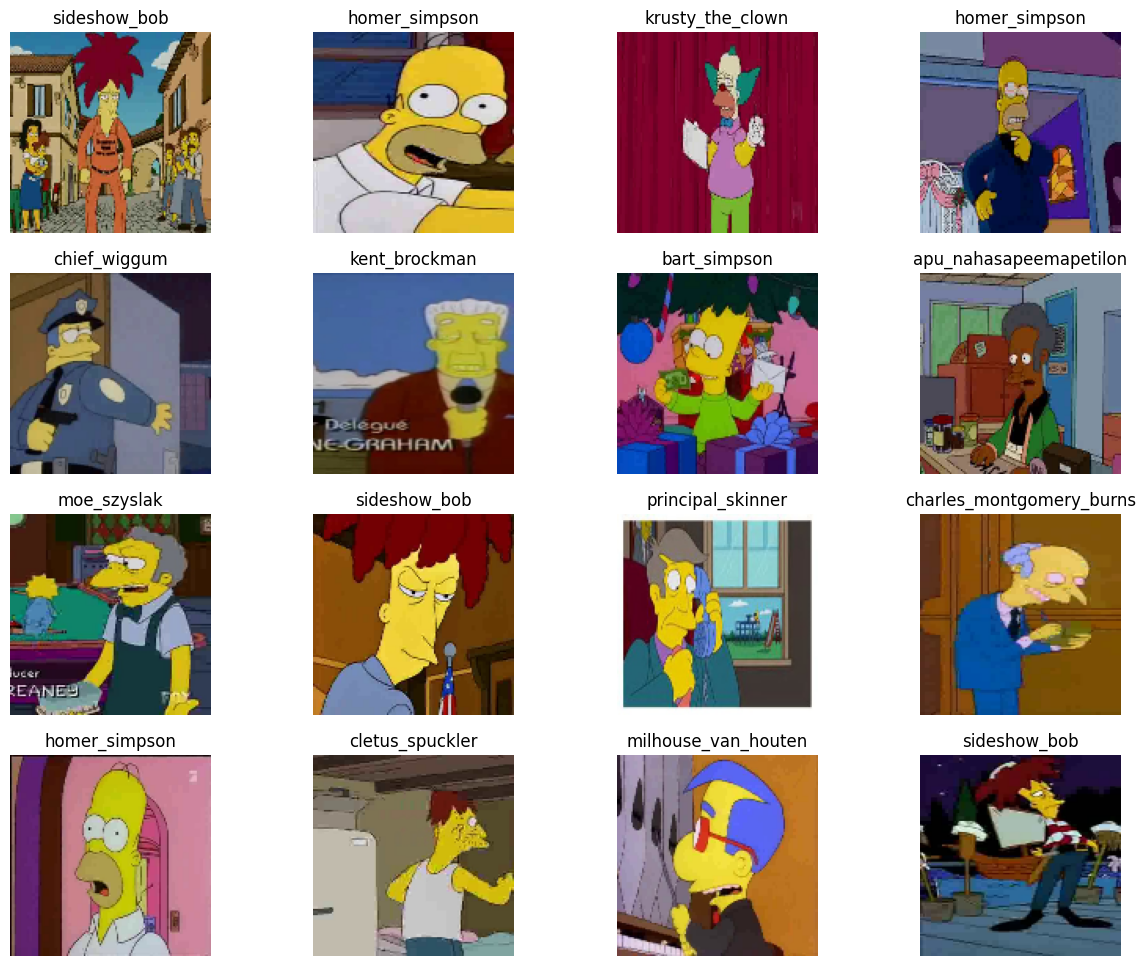

In [119]:
ids = np.random.randint(0, len(target), 16)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
for i in range(0, 4):
    for j in range(0, 4):
        axs[i, j].imshow(images[ids[i * 4 + j]])
        axs[i, j].set_title(decipher(target[ids[i * 4 + j]]))
        axs[i, j].axis("off")

In [120]:
X = np.array(images)
y = np.array(target)

In [123]:
X.shape, y.shape

((20933, 128, 128, 3), (20933, 42))

In [124]:
import torch
import torch.utils.data as data

In [125]:
class SimpsonsDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.length = len(y)

    def __getitem__(self, item):
        target = torch.tensor(y[item], dtype=torch.int16)
        img = torch.tensor(X[item], dtype=torch.int16)
        return img, target

    def __len__(self):
        return self.length
    

In [127]:
train_dataset = SimpsonsDataset(X, y)
train_data = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [128]:
it = iter(train_data)
x, y = next(it)

Text(0.5, 1.0, 'lisa_simpson')

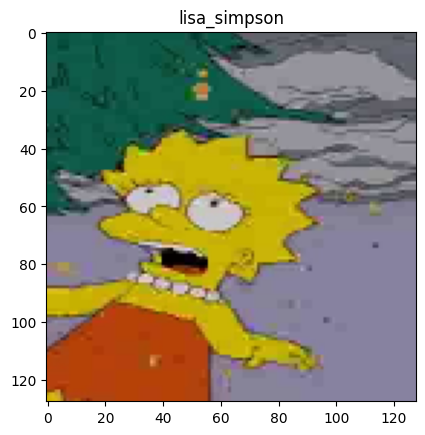

In [134]:
plt.imshow(x[1])
plt.title(decipher(y[1]))